# 📖 Tutorial: Build Your First AI Model (CNN) with PyTorch
Welcome! This is your first hands-on project to bridge the gap between using AI (like in ComfyUI) and building it.

Our Goal: Train a simple AI model called a Convolutional Neural Network (CNN) to recognize and classify images of clothing (like sneakers, shirts, and bags) from the Fashion-MNIST dataset.

Why? This single project teaches you the entire end-to-end workflow of a deep learning engineer. These are the exact concepts (layers, optimizers, loss) that power everything from GenAI to self-driving cars. This is the perfect project for your B.Tech resume.

## Section 1: The Setup (Our "Lab")
First, we set up a clean, isolated environment for our project.

Why we do this: We use a virtual environment (venv) to keep our project's libraries (like PyTorch) separate from your computer's main Python. This prevents version conflicts and is a standard practice for all professional developers.

In your terminal (cmd or PowerShell):

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Check our version to make sure it's working
print("PyTorch Version:", torch.__version__)

PyTorch Version: 2.5.1+cu121


### Why we do this:

torch: The main PyTorch library.

torch.nn: The "neural network" module. This is our box of Lego bricks (layers like Conv2d, Linear, etc.).

torch.optim: The "optimizer" module. This contains Adam, the engine that "tunes" our model.

torchvision: A helper library that lets us easily download datasets (like Fashion-MNIST) and apply image transformations.

## Step 2.2: Load the Data
We can't train a model without data. Here, we download, transform, and load the Fashion-MNIST dataset.

In [2]:
#1. Define a "transform"
# This tells pytorch how to prepare our imgs
transform = transforms.Compose([transforms.ToTensor(), #Convert images (from 0-255) to Tensors (from 0-1)
                                transforms.Normalize((0.5,),(0.5,))]) #Normalize to (-1, 1) for faster training
#2. Download and create the training dataset (will download automatically)
trainset = torchvision.datasets.FashionMNIST(root='./data', train = True, download=True,transform=transform)
#3. Create a "loader" for the training data
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)
#4. Do the same for the testing dataset
testset= torchvision.datasets.FashionMNIST(root='./data',train=False, download=True, transform=transform)
testloader= torch.utils.data.DataLoader(testset,batch_size=64,shuffle=False)
#5. Define human-readable class names
classes=('T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot')
print("Data loaded successfully")

Data loaded successfully


### Why we do this:

Transform: Neural networks "think" in numbers, specifically Tensors. The ToTensor() step converts our images into this format. Normalize centers our data, which helps the model learn more stably and quickly.

DataLoader: We can't feed all 60,000 images into the GPU at once. The DataLoader breaks the data into small batches (e.g., 64 images at a time) and shuffles it randomly, which is crucial for effective training.

## Step 2.3: Define the CNN Model
This is the "brain" of our AI. We're defining its architecture, layer by layer.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # This is our feature extraction "eye"
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # This is our classification "brain"
        self.classifier = nn.Sequential(
            nn.Linear(16 * 4 * 4, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10) 
        )

    # This defines the "forward pass" (how data flows through the layers)
    # THIS IS THE FIX: It is NOT indented under __init__
    def forward(self, x):
        x = self.conv_stack(x)
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        x = self.classifier(x)
        return x

# Create an instance of our network and send it to the GPU
net = Net()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

print(net)
print(f"\nModel is running on: {device}")

Net(
  (conv_stack): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

Model is running on: cuda:0


### Why we do this:

nn.Conv2d (Convolution): This is the core of a CNN. It's a "filter" that slides over the image to find patterns (like edges, corners, and textures).

nn.ReLU (Activation): A simple function that introduces non-linearity, allowing the model to learn complex relationships (not just straight lines).

nn.MaxPool2d (Pooling): This shrinks the image, keeping only the most important features. It makes the model faster and more robust.

nn.Linear (Fully Connected): This is the classic "brain" part that takes all the high-level features (like "I see a shoelace" and "I see a sole") and makes a final decision ("That's a Sneaker").

## Step 2.4: Define the Loss and Optimizer
Now we define how the model learns.

In [4]:
# 1. Loss Function (scorecard)
criterion = nn.CrossEntropyLoss()

# 2. Optimizer (study method)
#    We are defining this AFTER net.to(device), so it gets the GPU parameters.
optimizer = optim.Adam(net.parameters(), lr=0.001)

print("Loss function and optimizer are defined correctly.")

Loss function and optimizer are defined correctly.


### Why we do this:

Loss Function (criterion): This is the "scorecard." It measures how "wrong" the model's prediction is compared to the correct label. A high loss is bad, a low loss is good. Our goal is to minimize this.

Optimizer (optimizer): This is the "engine" of learning. It looks at the loss and then slightly adjusts all the model's internal parameters (weights) to make the loss lower.

Connection: This optim.Adam is the exact same "Adam" optimizer you select when training a LoRA in ComfyUI! You're just using it manually now.

## Step 2.5: The Training Loop
This is where the magic happens. We feed the data to the model and tell it to learn.

In [5]:
print('Starting Training...')

for epoch in range(5):  # loop over the dataset 5 times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # 1. Get a batch of [inputs, labels] from our loader
        #  IMPORTANT: Send your data to the 'device' (GPU)
        inputs, labels = data[0].to(device), data[1].to(device)

        # 2. Zero the gradients (important cleanup step)
        optimizer.zero_grad()

        # 3. FORWARD PASS: Make a prediction
        outputs = net(inputs)
        
        # 4. Calculate the "wrongness" (loss)
        loss = criterion(outputs, labels)
        
        # 5. BACKWARD PASS: Calculate how to fix the error
        loss.backward()
        
        # 6. OPTIMIZE: Update the model's weights
        optimizer.step()

        # Print stats so we can watch it learn
        running_loss += loss.item()
        if i % 200 == 199:    # Print every 200 batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

Starting Training...
[Epoch 1, Batch 200] loss: 0.968
[Epoch 1, Batch 400] loss: 0.595
[Epoch 1, Batch 600] loss: 0.547
[Epoch 1, Batch 800] loss: 0.487
[Epoch 2, Batch 200] loss: 0.437
[Epoch 2, Batch 400] loss: 0.417
[Epoch 2, Batch 600] loss: 0.396
[Epoch 2, Batch 800] loss: 0.372
[Epoch 3, Batch 200] loss: 0.354
[Epoch 3, Batch 400] loss: 0.348
[Epoch 3, Batch 600] loss: 0.354
[Epoch 3, Batch 800] loss: 0.336
[Epoch 4, Batch 200] loss: 0.325
[Epoch 4, Batch 400] loss: 0.321
[Epoch 4, Batch 600] loss: 0.323
[Epoch 4, Batch 800] loss: 0.306
[Epoch 5, Batch 200] loss: 0.290
[Epoch 5, Batch 400] loss: 0.310
[Epoch 5, Batch 600] loss: 0.291
[Epoch 5, Batch 800] loss: 0.296
Finished Training


#### Why we do this: This loop is the heartbeat of all deep learning.

Forward Pass: We "show" the model an image and ask "what is this?"

Calculate Loss: We "tell" the model it was wrong (e.g., "You said Pullover, but it was a T-shirt") and calculate a numerical "penalty" (the loss).

Backward Pass: This is the backpropagation you've heard of. The model calculates how much each tiny parameter contributed to the error.

Optimize: The Adam optimizer uses those calculations to "nudge" every parameter in the right direction to make it less wrong next time.

### Step 2.6: Test the Model
The training is done. But how smart is our model really? We must test it on the testloader data, which it has never seen before.

In [6]:
correct = 0
total = 0
# We don't need to calculate gradients (no learning) during testing
with torch.no_grad():
    for data in testloader:
        # Move the test images and labels to the GPU
        images, labels = data[0].to(device), data[1].to(device)
        
        # Run the images through our trained model
        outputs = net(images)
        
        # Find the class with the highest score
        _, predicted = torch.max(outputs.data, 1)
        
        # Count our correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the final percentage
accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10,000 test images: {accuracy:.2f} %')

Accuracy of the network on the 10,000 test images: 88.57 %


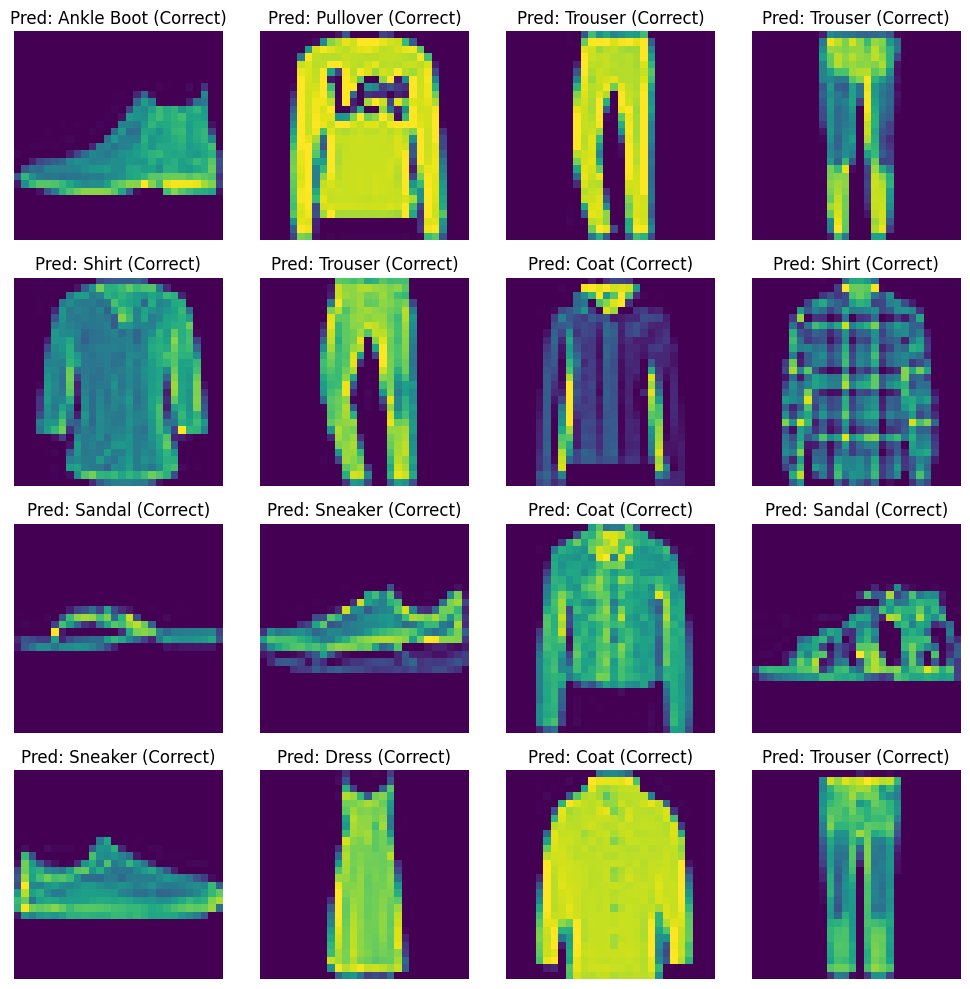

In [7]:
# 1. Get one batch of test images and labels
dataiter = iter(testloader)
images, labels = next(dataiter)

# 2. Move this new batch to the GPU
images_gpu = images.to(device)
labels_gpu = labels.to(device)

# 3. Get predictions from your trained model
with torch.no_grad():
    outputs = net(images_gpu)
_, predicted = torch.max(outputs, 1)

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # Un-normalize the image (reverses our transform)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off') # Hide the x/y axes

# 1. Create a figure to plot on
plt.figure(figsize=(10, 10))

# 2. Plot the first 16 images from the batch
for i in range(16):
    plt.subplot(4, 4, i + 1)
    imshow(images[i])
    # Set the title to the prediction. Add (Correct) if it matches the label.
    prediction_text = f"Pred: {classes[predicted[i]]}"
    if predicted[i] == labels_gpu[i]:
        prediction_text += " (Correct)"
    plt.title(prediction_text)

# 3. Show the final plot
plt.tight_layout()
plt.show()

In [ ]:
#Save your file for future use(demonstrated in second test)
PATH = './my_cnn_model.pth'
torch.save(net.state_dict(), PATH)
print(f"Model saved to {PATH}")